In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import gc
from matplotlib import rcParams
import matplotlib.ticker as plticker
from ipywidgets import widgets
from IPython.display import display

rcParams['figure.figsize'] = 5,15
basepath = '/home/rishi/Projects/Personal-Website/static/images/'
%matplotlib inline

In [2]:
cols = ['MaterialType','CheckoutYear','CheckoutMonth','Checkouts']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=1000000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    checkout_dfs.append(df)

In [3]:
checkouts = pd.concat(checkout_dfs)

In [59]:
del(checkout_dfs)
del(df)
gc.collect()

19915

In [170]:
checkouts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34892623 entries, 0 to 34892622
Data columns (total 4 columns):
MaterialType     object
CheckoutYear     int64
CheckoutMonth    int64
Checkouts        int64
dtypes: int64(3), object(1)
memory usage: 1.0+ GB


In [171]:
checkouts.MaterialType.value_counts()

BOOK             19594797
EBOOK             4073379
SOUNDDISC         4009527
VIDEODISC         3035380
AUDIOBOOK         1708745
                   ...   
REMOTESEN               3
SECTION                 2
NONPROJGRAPH            2
MAP, VIEW               1
ER, VIDEOCASS           1
Name: MaterialType, Length: 66, dtype: int64

In [4]:
filt1 = checkouts.MaterialType == 'BOOK'
filt2 = checkouts.MaterialType == 'EBOOK'
filt3 = checkouts.MaterialType == 'AUDIOBOOK'

df = (checkouts[filt1 | filt2 | filt3]
      .groupby(['CheckoutYear', 'MaterialType'], as_index=False)
      .agg({'Checkouts': 'sum'})
)

In [17]:
t = (theme(panel_background=element_blank(), plot_background=element_blank(),
           panel_grid_major=element_blank(), panel_grid_minor=element_blank(),
           axis_line_x=element_text(color='white'),
           title = element_text(color='white', size=18),
           axis_text_x=element_text(color='white', size=18),
           axis_text_y=element_text(color='white', size=18),
           axis_title=element_text(color='white', size=17),
           legend_background=element_blank(),
           legend_text=element_text(color='white', size=15),
           legend_title=element_blank()))

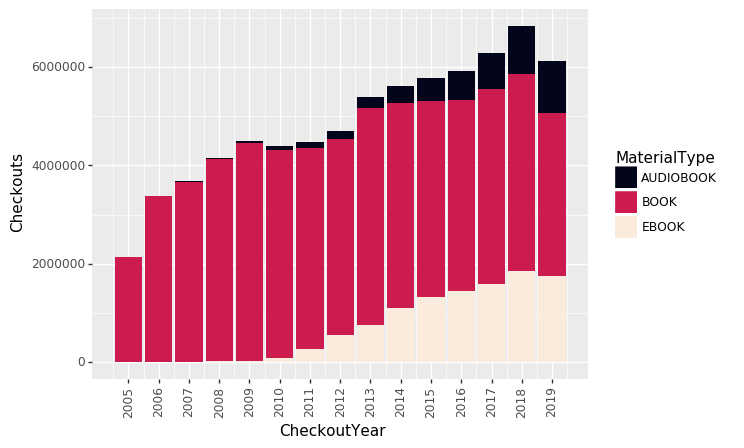

<ggplot: (8757870999473)>

In [11]:
g = (ggplot(df)
 + aes(x='CheckoutYear', y='Checkouts', fill='MaterialType')
 + geom_bar(stat='identity')
 + scale_x_continuous(breaks=range(2005,2020))
 + scale_fill_cmap_d('rocket')
 + theme(axis_text_x=element_text(rotation=90))
#  + scale_fill_brewer(type='qual', palette='Set3')
)

g

In [12]:
ggsave(g+t, height=10, width=10, filename=basepath+"type_year.png")

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/type_year.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [60]:
df = (checkouts
      .groupby(['CheckoutYear','CheckoutMonth'])
      .agg({'Checkouts': 'sum'})
      .groupby(level=0, group_keys=False)
      .apply(lambda x : (x - x.mean())/x.std())
      .reset_index()
      .pivot(index='CheckoutYear', columns='CheckoutMonth', values='Checkouts')
     )

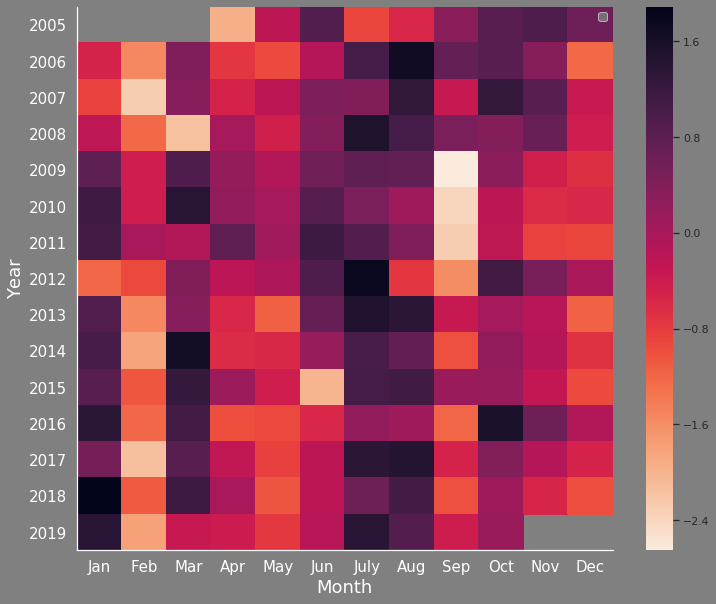

In [61]:
rcParams['figure.figsize'] = 12,10
rcParams['savefig.transparent'] = True
rcParams["legend.fontsize"] = 18
# rcParams["legend.textcolor"] = 'white'
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False})
# fig.patch.set_alpha(0.0) 
xtick_labs = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# sns.set_style('darkgrid')
sns.axes_style({'font.color':'white', 'ytick.color':'white',
                        'ytick.label.color': 'white',
                       })
year_vs_month = sns.heatmap(df, cmap='rocket_r', xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                             'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# year_vs_month.set_xticks(ticks=)
year_vs_month.set_yticklabels(range(2005,2020), fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
year_vs_month.set_xticklabels(xtick_labs, fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
year_vs_month.set_ylabel("Year", fontdict={'color': 'white', 'fontsize': 18})
year_vs_month.set_xlabel("Month", fontdict={'color': 'white', 'fontsize': 18})
year_vs_month.legend({'font.color':'white'})

fig = year_vs_month.get_figure()
# fig.savefig('/home/rishi/Projects/Personal-Website/static/images/year_vs_month.png')
sns.despine()

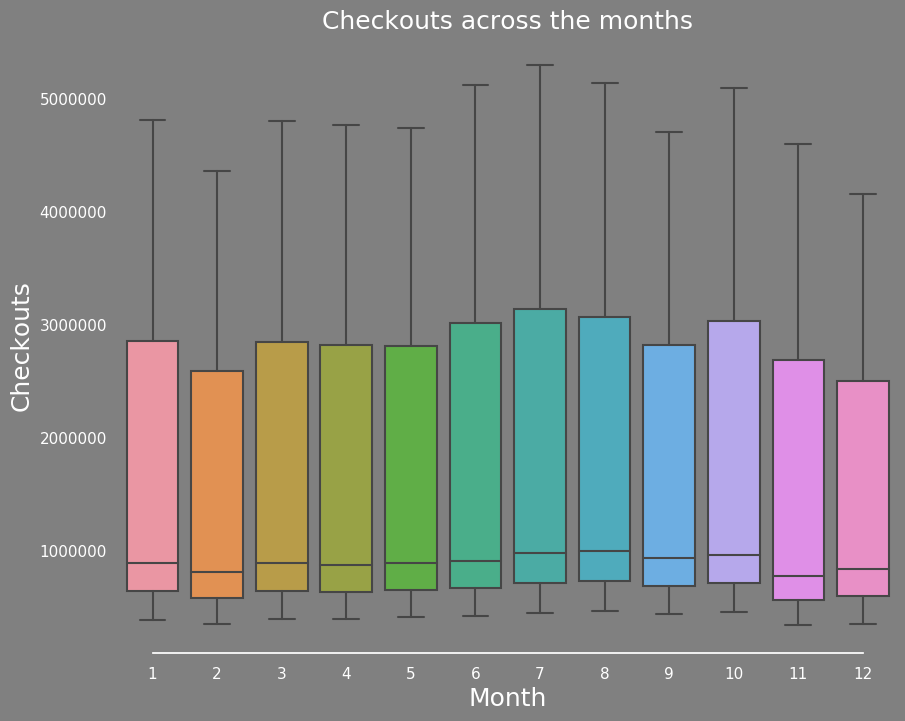

In [400]:
# sns.reset_defaults()
rcParams['figure.figsize'] = 10,8
rcParams['savefig.transparent'] = True
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False,
            'xtick.color': 'white', 'ytick.color': 'white', 'axes.spines.bottom': False
           })
box_mat = sns.boxplot(x="CheckoutMonth", y="Checkouts",
            data=df)

box_mat.set_ylabel("Checkouts", fontdict={'color': 'white', 'fontsize': 18})
box_mat.set_xlabel("Month", fontdict={'color': 'white', 'fontsize': 18})
box_mat.set_title("Checkouts across the months", fontdict={'color':'white', 'fontsize':18})
sns.despine(left=True, trim=True)
fig = box_mat.get_figure()
fig.savefig('/home/rishi/Projects/Personal-Website/static/images/checkouts_months.png')

In [22]:
cols = ['MaterialType', 'CheckoutYear','Checkouts', 'Subjects']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = (pd.DataFrame(chunk)
          .set_index('MaterialType')
          .loc[['BOOK', 'EBOOK', 'AUDIOBOOK'], ['CheckoutYear', 'Checkouts', 'Subjects']]
#           .dropna(subset=['Subjects'])
          .assign(Subjects = lambda x: x.Subjects.str.partition(',')[0])
         )
    
    checkout_dfs.append(df)

In [23]:
checkouts = pd.concat(checkout_dfs)

In [32]:
 df = (checkouts
       .groupby('Subjects', as_index = False)
       .agg({'Checkouts': 'sum'})
       .sort_values(by = 'Checkouts', ascending = False)
      )[:20]
df.Subjects = pd.Categorical(df.Subjects, df.Subjects)

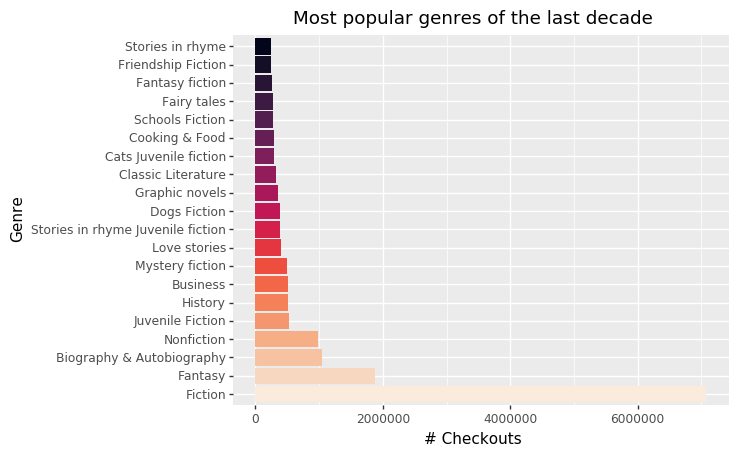

<ggplot: (8726377660169)>

In [33]:
g = (ggplot(df[:20])
 + aes(x='Subjects', y='Checkouts', fill='Subjects')
 + geom_bar(stat='identity', show_legend=False)
 + coord_flip()
 + scale_fill_cmap_d('rocket_r')
 + ggtitle(title="Most popular genres of the last decade")
 + labs(y='# Checkouts', x='Genre')
)
g

In [126]:
ggsave(g+t, width=10, height=10, filename=basepath + 'top_genres.png')

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/top_genres.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


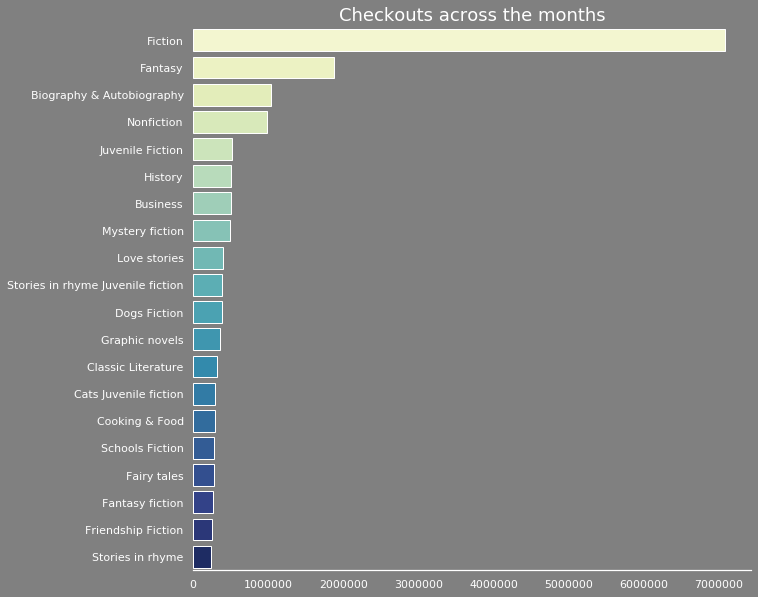

In [73]:
# sns.reset_defaults()
sns.set_context("paper")
rcParams['figure.figsize'] = 10,10
rcParams['savefig.transparent'] = True
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False,
            'xtick.color': 'white', 'ytick.color': 'white', 'axes.spines.bottom': False
           })
box_subjects = sns.barplot(x="Checkouts", y="Subjects",data=df[:20], palette='YlGnBu')
box_subjects.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
box_subjects.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})
# box_subjects.set_xtick(fontdict={'fontsize': 18 })
box_subjects.set_title("Checkouts across the months", fontdict={'color':'white', 'fontsize':18})
sns.despine(left=True)
fig = box_subjects.get_figure()
fig.savefig('/home/rishi/Projects/Personal-Website/static/images/top_genres.png', bbox_inches='tight')

In [20]:
top_subjs = checkouts.Subjects.value_counts()[:20]

In [21]:
df = (checkouts[ checkouts.Subjects.isin(top_subjs.index)]
      .groupby(['CheckoutYear', 'Subjects'], as_index = False)
      .agg({'Checkouts': 'sum'})
     )

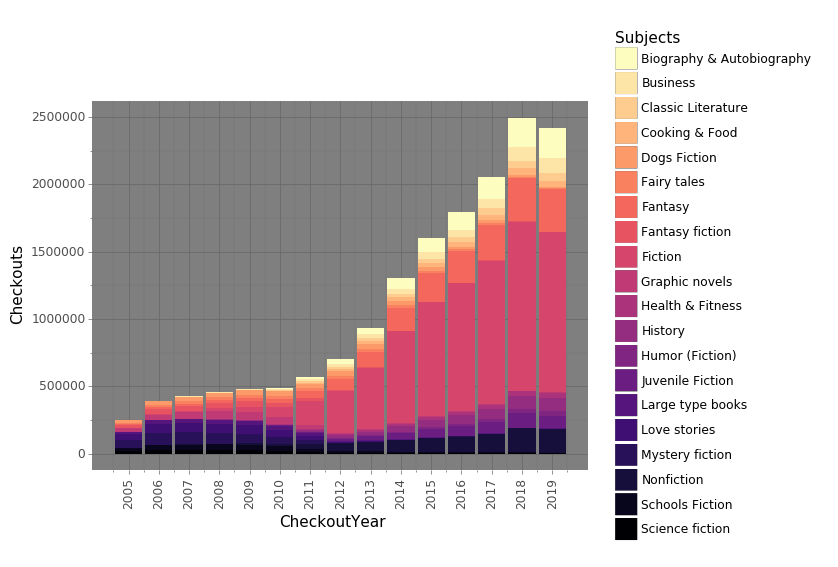

<ggplot: (8757647843725)>

In [22]:
g =(ggplot(df)
    + aes('CheckoutYear', 'Checkouts', fill='Subjects')
    + geom_bar(stat='identity')
    + theme_dark()
    + scale_fill_cmap_d('magma_r')
    + scale_x_continuous(breaks=range(2005,2020))
    + theme(axis_text_x=element_text(rotation=90))
   )
g

In [23]:
ggsave(g+t, width=10, height=10, filename=basepath+ 'subjects_year.png')

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/subjects_year.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [127]:
def normalized(x):
    var = (x - x.mean())/x.std()
    return var

df = (checkouts[ checkouts.Subjects.isin(top_subjs.index)]
      .groupby(['CheckoutYear', 'Subjects'])
      .agg({'Checkouts': 'sum'})
      .groupby('CheckoutYear')
      .transform(normalized)
      .reset_index()
      .pivot(index='Subjects', columns='CheckoutYear', values='Checkouts')
#       .groupby('CheckoutYear')
#       .transform({'Checkouts':normalized})
     )

In [128]:
df

,CheckoutYear,Subjects,Checkouts
0,2005,Biography & Autobiography,-0.735620
1,2005,Business,-0.731752
2,2005,Classic Literature,-0.722868
3,2005,Cooking & Food,-0.744020
4,2005,Dogs Fiction,0.292996
...,...,...,...
295,2019,Love stories,-0.454463
296,2019,Mystery fiction,-0.453887
297,2019,Nonfiction,0.206722
298,2019,Schools Fiction,-0.444420


Text(0.5, 1, 'Genres over the years')

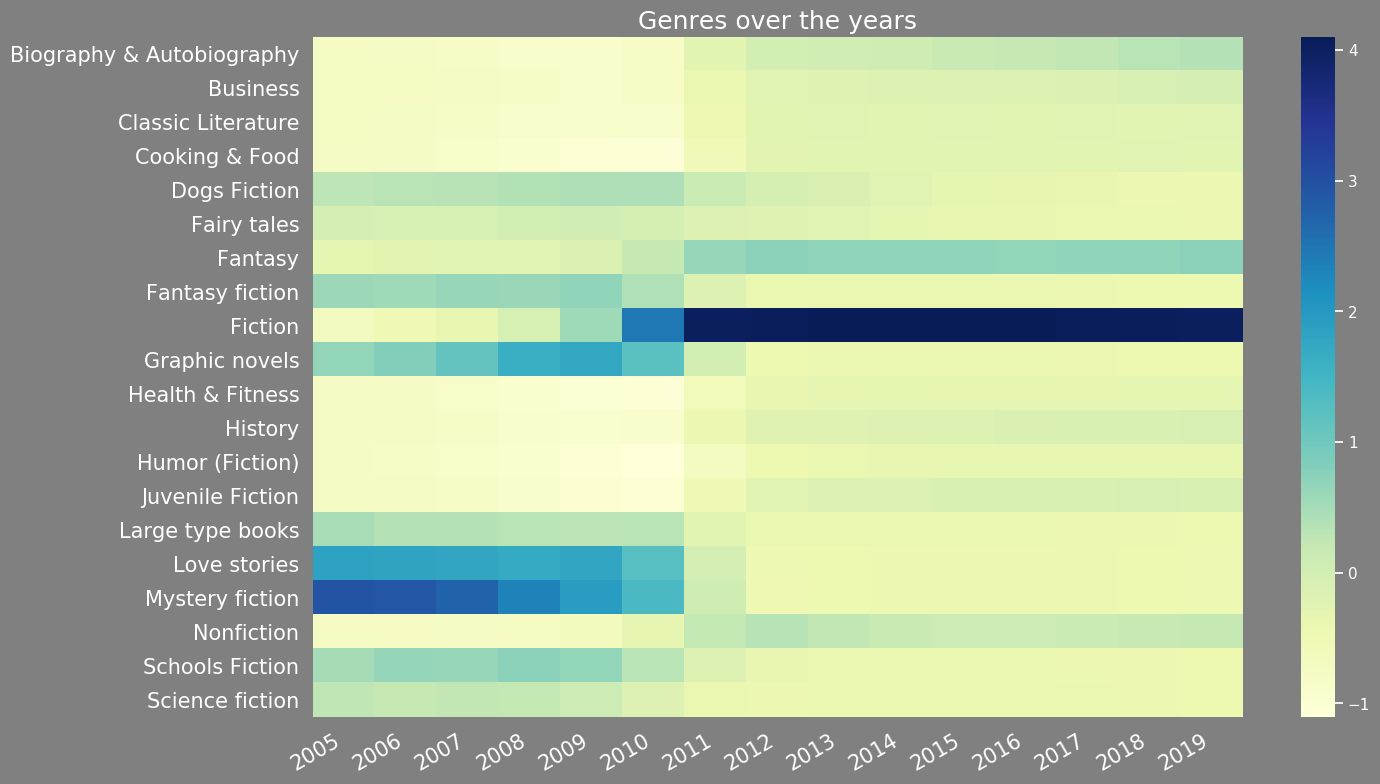

In [471]:
rcParams['figure.figsize'] = 15,10

genres = sns.heatmap(df, cmap='YlGnBu')
genres.set_yticklabels(df.index, fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
genres.set_xticklabels(range(2005,2020), fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
genres.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
genres.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})
genres.get_figure().autofmt_xdate()
genres.set_title("Genres over the years", fontdict={'color':'white', 'fontsize':18})

In [478]:
genres.get_figure().savefig(basepath+"genre_years.png")

In [ ]:
def normalized(x):
    var = (x - x.mean())/x.std()
    return var

df = (checkouts[ checkouts.Subjects.isin(top_subjs.index)]
      .groupby(['CheckoutYear', 'Subjects'])
      .agg({'Checkouts': 'sum'})
      .groupby('CheckoutYear')
      .transform(normalized)
      .reset_index()
#       .pivot(index='Subjects', columns='CheckoutYear', values='Checkouts')
#       .groupby('CheckoutYear')
#       .transform({'Checkouts':normalized})
     )

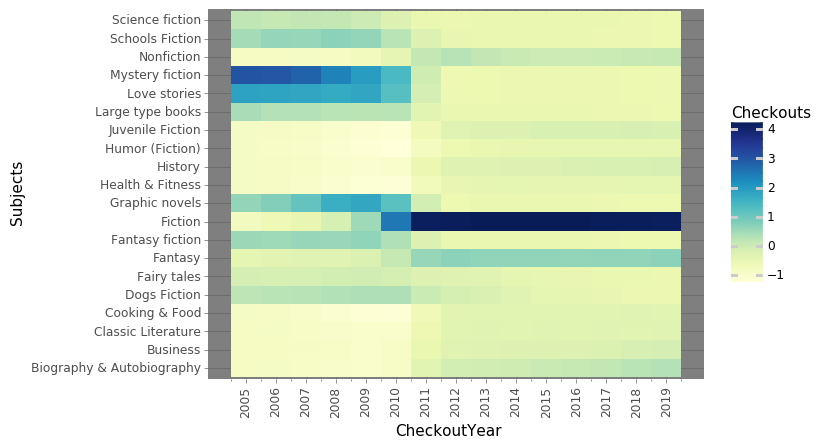

<ggplot: (8757863198649)>

In [134]:
g = (ggplot(df)
 + aes('CheckoutYear', 'Subjects', fill='Checkouts')
 + geom_tile()
 + scale_fill_cmap('YlGnBu')
 + theme_dark()
#  + scale_y_continuous(breaks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                                                   'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
 + scale_x_continuous(breaks=range(2005,2020))
 + theme(axis_text_x=element_text(rotation=90))
)
g

In [138]:
ggsave(g+t, width=15, height=15, filename=basepath+'genre_years.png')

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 15 x 15 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/genre_years.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [473]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Subjects', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[(df.CheckoutYear == 2018) | (df.CheckoutYear == 2019)]
#     df = (pd.DataFrame(chunk)
#           .set_index('CheckoutYear','MaterialType')
#           .loc[(['2010', '2019'], ['BOOK', 'EBOOK', 'AUDIOBOOK'])]
# #           .dropna(subset=['Subjects'])
#           .assign(Subjects = lambda x: x.Subjects.str.partition(',')[0])
#          )
    
    checkout_dfs.append(df)

In [474]:
checkouts = pd.concat(checkout_dfs)

In [475]:
df_2019 = (checkouts[checkouts.CheckoutYear == 2019]
           .assign(Title = lambda x: x.Title.str.partition('/')[0])
           .set_index('MaterialType')
           .loc[['BOOK', 'EBOOK', 'AUDIOBOOK']]
           .reset_index()
          )

df_2019.Title = (df_2019.Title.str.strip().str.lower().str.partition('a memoir')[0].str.replace(':','')
.str.replace("\(unabridged\)", '').str.strip())

ranked = (df_2019
          .groupby('Title', as_index=False)
          .agg({'Checkouts': 'sum'})
          .set_index('Title')
         )

In [476]:
ranked.nlargest(20, 'Checkouts')

,Checkouts
Title,
becoming,18250
educated,13067
where the crawdads sing,12475
"crazy rich asians crazy rich asians series, book 1",6513
the library book,5937
the life-changing magic of tidying up the japanese art of decluttering and organizing,5000
you are a badass how to stop doubting your greatness and start living an awesome life,3991
little fires everywhere,3830
so you want to talk about race,3693


In [2]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Subjects', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[df.Title.str.lower().str.contains('hunger games')
            | df.Title.str.lower().str.contains('catching fire')
            | df.Title.str.lower().str.contains('mockingjay') ]
    
    checkout_dfs.append(df)

In [3]:
checkouts = pd.concat(checkout_dfs)

checkouts.Title = checkouts.Title.str.lower().str.partition('/')[0].str.partition(':')[0].str.partition('[')[0].str.strip()

In [19]:
df = (checkouts
      [(checkouts.Title == 'the hunger games') | (checkouts.Title == 'catching fire') | (checkouts.Title == 'mockingjay')]
      .assign(Date =
              lambda x: pd.to_datetime(
                  checkouts.CheckoutYear.astype(str)
                  + '-'
                  + checkouts.CheckoutMonth.astype(str)
                  + '-'
                  + '01'
              )
             )
      .drop(columns=['Creator', 'Subjects', 'CheckoutMonth'])
      .dropna(subset=['MaterialType'])
      .set_index('MaterialType')
      .loc[['BOOK', 'AUDIOBOOK']]
      .reset_index()
      .groupby(['Title','Date']).agg({'Checkouts': 'sum'}, as_index=False)
      .reset_index()
      .pivot(index='Date', columns='Title', values='Checkouts')
      .fillna(0)
      .sort_values(by='Date', ascending=False)
     )

# cols = ['the hunger games', 'catching fire', 'mockingjay']
# df = df[cols]

In [20]:
df

Title,catching fire,mockingjay,the hunger games
Date,,,
2019-10-01,93.0,81.0,128.0
2019-09-01,87.0,68.0,124.0
2019-08-01,100.0,98.0,163.0
2019-07-01,95.0,86.0,136.0
2019-06-01,81.0,68.0,134.0
...,...,...,...
2009-01-01,0.0,0.0,63.0
2008-12-01,0.0,0.0,23.0
2008-11-01,0.0,0.0,22.0


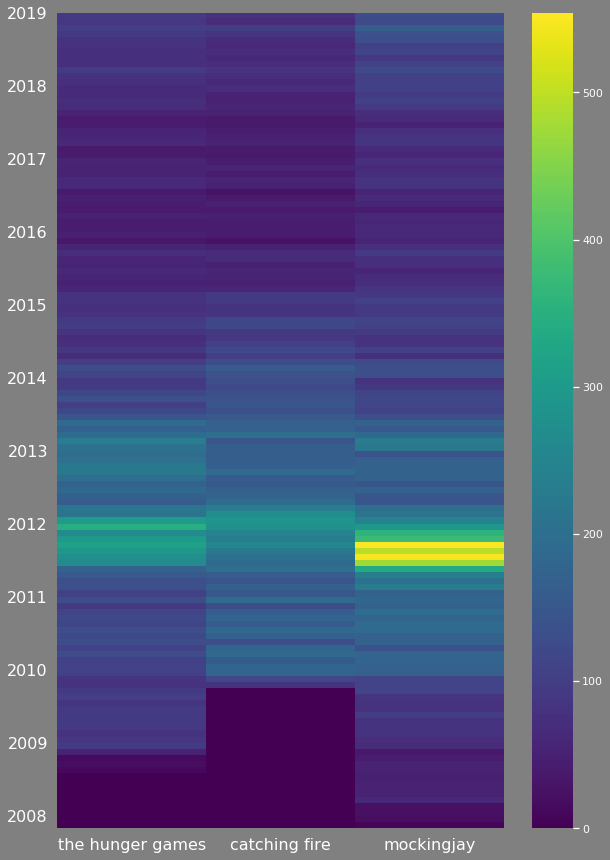

In [21]:
rcParams['figure.figsize'] = 10,15
rcParams['savefig.transparent'] = True
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False,
            'xtick.color': 'white', 'ytick.color': 'white', 'axes.spines.bottom': False
           })

g = sns.heatmap(df, cmap='viridis',xticklabels=['the hunger games', 'catching fire', 'mockingjay'])
g.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
g.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})
loc = plticker.MultipleLocator(base=12) # this locator puts ticks at regular intervals
g.set_yticklabels(range(2020, 2007, -1), fontdict={'fontsize':16})
g.set_xticklabels(cols, fontdict={'fontsize':16})
# g.legend(title="Checkouts")
g.yaxis.set_major_locator(loc)
fig = g.get_figure()
fig.savefig(basepath + 'hunger_games.png')

In [44]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Subjects', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[df.Title.str.lower().str.contains('harry potter and the')]
    
    checkout_dfs.append(df)

In [45]:
checkouts = pd.concat(checkout_dfs)

checkouts .Title = (checkouts
                    .Title.str.lower().str.partition('/')[0]
                    .str.partition(':')[0].str.replace("'", '')
                    .str.partition('[')[0].str.strip()
                   )

In [46]:
def new_title(x):
    ret = ''
    if x.Title == 'harry potter and the sorcerers stone':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the chamber of secrets':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the prisoner of azkaban':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the goblet of fire':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the order of the phoenix':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the half-blood prince':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the deathly hallows':
        ret = '1.' + x.Title
    return ret

df = (checkouts
      [(checkouts.Title == 'harry potter and the sorcerers stone')
       | (checkouts.Title == 'harry potter and the chamber of secrets')
       | (checkouts.Title == 'harry potter and the prisoner of azkaban')
       | (checkouts.Title == 'harry potter and the goblet of fire')
       | (checkouts.Title == 'harry potter and the order of the phoenix')
       | (checkouts.Title == 'harry potter and the half-blood prince')
       | (checkouts.Title == 'harry potter and the deathly hallows')
      ]
      .assign(Date =
              lambda x: pd.to_datetime(
                  checkouts.CheckoutYear.astype(str)
                  + '-'
                  + checkouts.CheckoutMonth.astype(str)
                  + '-'
                  + '01'
              )
             )
      .dropna(subset=['MaterialType'])
      .set_index('MaterialType')
      .loc[['BOOK', 'EBOOK', 'AUDIOBOOK']]
      .reset_index()
      .drop(columns=['Creator', 'Subjects', 'CheckoutMonth'])
#       .reset_index()
      .groupby(['Title','Date']).agg({'Checkouts': 'sum'}, as_index=False)
      .reset_index()
      .sort_values(by='Checkouts')
      .pivot(index='Date', columns='Title', values='Checkouts')
      .fillna(0)
      .sort_values(by='Date', ascending=False)
      
     )

In [47]:
cols= ['harry potter and the sorcerers stone',
       'harry potter and the chamber of secrets',
       'harry potter and the prisoner of azkaban',
       'harry potter and the goblet of fire',
       'harry potter and the order of the phoenix',
       'harry potter and the half-blood prince',
       'harry potter and the deathly hallows']
df = df[cols]

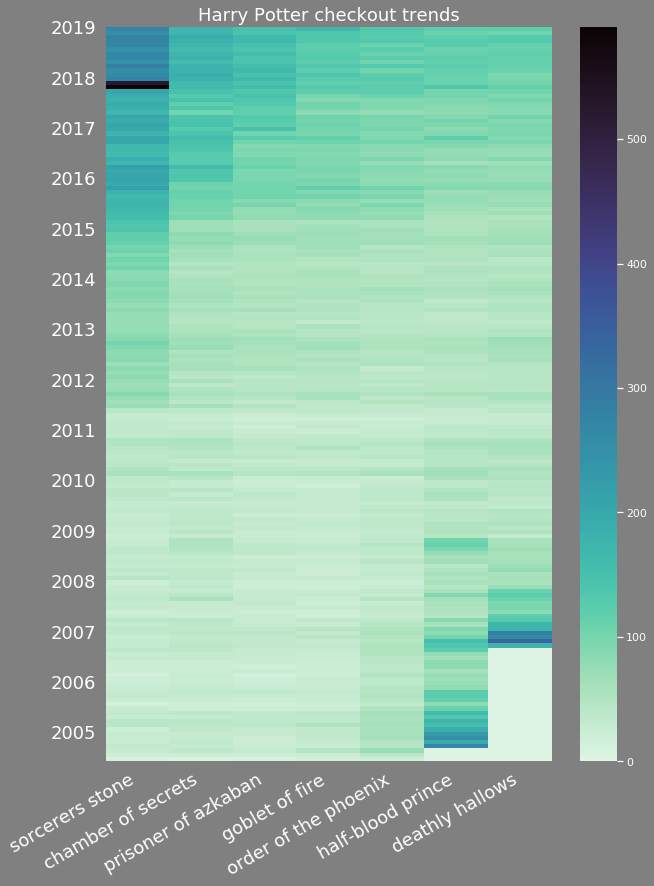

In [49]:
rcParams['figure.figsize'] = 10,15
cols2 = ['sorcerers stone',
       'chamber of secrets',
       'prisoner of azkaban',
       'goblet of fire',
       'order of the phoenix',
       'half-blood prince',
       'deathly hallows']
g = sns.heatmap(df, cmap='mako_r', xticklabels=cols)
g.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
g.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})

g.set_xticklabels(cols2, fontdict={'fontsize':18})
g.get_figure().autofmt_xdate()
loc = plticker.MultipleLocator(base=12) # this locator puts ticks at regular intervals
g.set_yticklabels(range(2020, 2004, -1), fontdict={'fontsize': 18})
g.yaxis.set_major_locator(loc)
g.set_title("Harry Potter checkout trends", fontdict={'color':'white', 'fontsize':18})
fig = g.get_figure()
fig.savefig(basepath + 'hp.png')


In [50]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[df.Title.str.lower().str.contains('a song of ice and fire')]
    
    checkout_dfs.append(df)

In [51]:
checkouts = pd.concat(checkout_dfs)

checkouts.Title = checkouts.Title.str.lower().str.partition(':')[0].str.strip()

In [52]:
df = (checkouts
      .assign(Date =
              lambda x: pd.to_datetime(
                  checkouts.CheckoutYear.astype(str)
                  + '-'
                  + checkouts.CheckoutMonth.astype(str)
                  + '-'
                  + '01'
              )
             )
      .dropna(subset=['MaterialType'])
      .reset_index()
      .drop(columns=['Creator', 'CheckoutMonth'])
      .groupby(['Title','Date']).agg({'Checkouts': 'sum'}, as_index=False)
      .reset_index()
      .sort_values(by='Checkouts')
      .pivot(index='Date', columns='Title', values='Checkouts')
      .fillna(0)
      .sort_values(by='Date', ascending=False)
      
     )

In [53]:
checkouts.Title.unique()

array(['a storm of swords', 'a clash of kings', 'a dance with dragons',
       'a feast for crows', 'a game of thrones', 'beyond the wall',
       'clash of kings book two of a song of ice and fire'], dtype=object)

In [54]:
cols= ['a game of thrones',
       'a clash of kings',
       'a storm of swords',
       'a feast for crows',
       'a dance with dragons',
#        'beyond the wall'
      ]
df = df[cols]

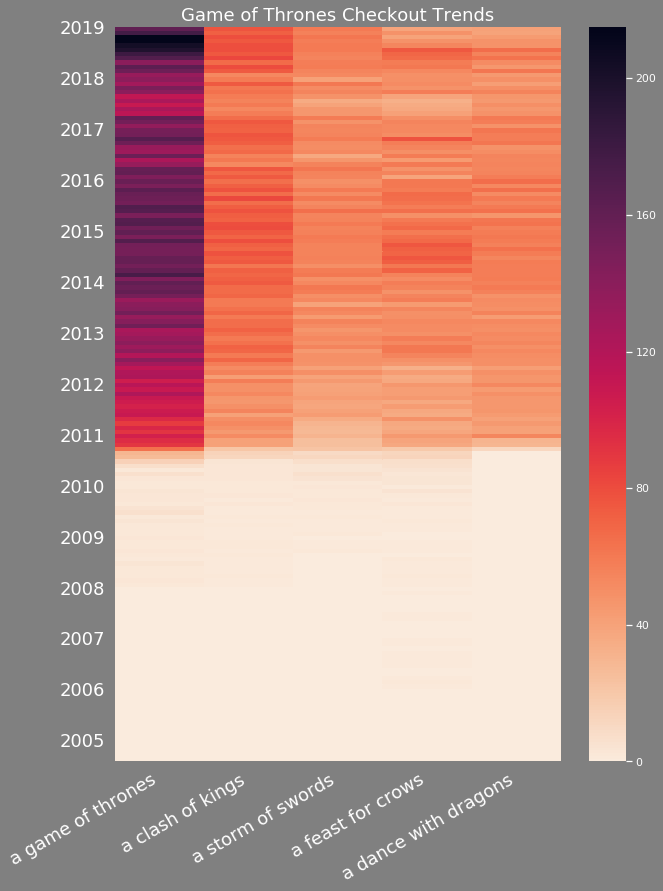

In [56]:
rcParams['figure.figsize'] = 10,15

g = sns.heatmap(df, cmap='rocket_r', xticklabels=cols)
g.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
g.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})

g.set_xticklabels(cols, fontdict={'fontsize':18})
g.get_figure().autofmt_xdate()

loc = plticker.MultipleLocator(base=12) # this locator puts ticks at regular intervals
g.set_yticklabels(range(2020, 2004, -1), fontdict={'fontsize': 18})
g.yaxis.set_major_locator(loc)
g.set_title("Game of Thrones Checkout Trends", fontdict={'color':'white', 'fontsize':18})
fig = g.get_figure()
fig.savefig(basepath + 'got.png')
# g.annotate('a', xy=(10,pd.to_datetime('2016-12-31')), xytext=(10,pd.to_datetime('2016-12-31')))
# g.set_facecolor('xkcd:salmon')
